# Time Series or Sequences Forecasting - A Brief Review and Exercise

### Content
1. Why this topic?
2. What is time series?
2. Why we discuss about time series?
3. How do we model and forecast?
4. Let's try forecasting!

> Reference: 
> - https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction
> - https://www.coursera.org/learn/time-series-survival-analysis/

---

## What is Time Series Data?

- Data recorded over a period of time.
- Time step should be constant.

Essentially a sequenced data where order is important.

## Why Do We Discuss About Time Series?

- A lot of data is in time series.
- Time series analysis is insightful. We want to know why things happen. 
- Time series forecasting is cool. We love to know when and what things will happen.

Value to Business ...

## How Do We Model and Forecast?
1. Naive approach
    - Shift
    - Moving Average
    - Smoothing
    - Differencing
2. Autoregressive and moving average models
    - ARMA, ARIMA-X, SARIMA-X
    - ACF, PACF. p, m, q
    - Stationary test
    - Decomposition: Trend, Seasonality, Noise
3. Sequential Neural Network
    - RNN, LSTM
    - Non stationary

## Let's Try Forecasting using Sequential Neural Network

In [1]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0']


In [2]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import os
import sys
import json
import warnings
warnings.simplefilter(action='ignore')

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ.pop('TF_CONFIG', None)
# if '.' not in sys.path:
#   sys.path.insert(0, '.')

# tf_config = {
#     'cluster': {
#         'worker': ['localhost:12345']
#     },
#     'task': {'type': 'worker', 'index': 0}
# }
# # tf_config['task']['index'] = 1
# os.environ['TF_CONFIG'] = json.dumps(tf_config)
strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


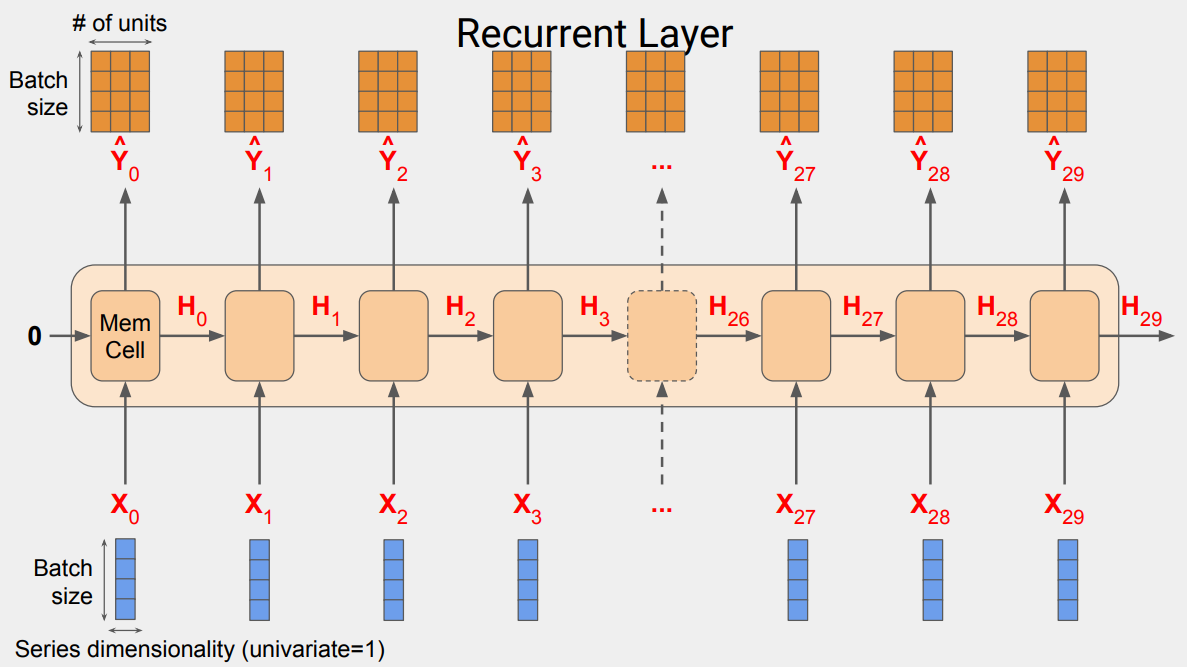

### Daily Max Temperatures Example

<AxesSubplot:xlabel='Date'>

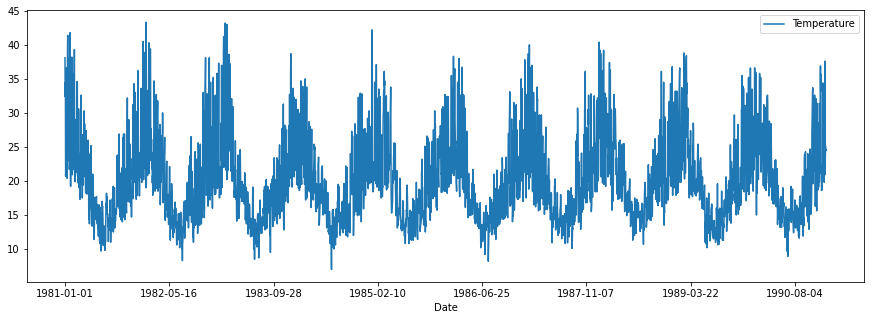

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv"
temp_df = pd.read_csv(url)

time_series = temp_df.Date
temp_series = temp_df.Temperature

temp_df.set_index(temp_df.Date, inplace=True)
temp_df.plot(figsize=(15, 5))

In [4]:
temp_df.head()

,Date,Temperature
Date,,
1981-01-01,1981-01-01,38.1
1981-01-02,1981-01-02,32.4
1981-01-03,1981-01-03,34.5
1981-01-04,1981-01-04,20.7
1981-01-05,1981-01-05,21.5


### Define Some Helper Functions

In [9]:
def train_val_split(time, series, time_step):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid


def windowed_dataset(series, window_size, batch_size, shuffle_buffer, output_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + output_size, shift=output_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + output_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-output_size], w[-output_size:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)


def create_model(window_size):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
#         tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mse"])
    return model


def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
OUTPUT_SIZE = 1

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(time_series, temp_series, SPLIT_TIME)

# Apply the transformation to the training set
train_set = windowed_dataset(
    series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE, output_size=1)

In [12]:
# Save an instance of the model
model = create_model(WINDOW_SIZE)

# Train it
history = model.fit(train_set, epochs=10)

Epoch 1/10
77/77 [==============================] - 5s 29ms/step - loss: 8.3016 - mse: 129.6967
Epoch 2/10
77/77 [==============================] - 2s 29ms/step - loss: 4.1050 - mse: 37.4501
Epoch 3/10
77/77 [==============================] - 2s 29ms/step - loss: 3.7051 - mse: 32.8395
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 2.7321 - mse: 20.0364
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 2.5474 - mse: 17.1050
Epoch 6/10
77/77 [==============================] - 2s 29ms/step - loss: 2.4815 - mse: 16.2779
Epoch 7/10
77/77 [==============================] - 2s 28ms/step - loss: 2.4161 - mse: 15.7349
Epoch 8/10
77/77 [==============================] - 2s 28ms/step - loss: 2.4147 - mse: 15.7042
Epoch 9/10
77/77 [==============================] - 2s 28ms/step - loss: 2.3965 - mse: 15.4630
Epoch 10/10
77/77 [==============================] - 2s 29ms/step - loss: 2.4479 - mse: 15.9696


113/113 [==============================] - 2s 11ms/step


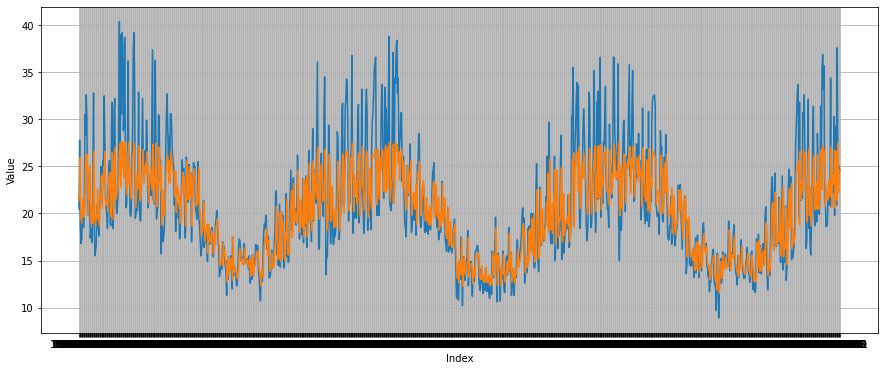

In [13]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, temp_series, WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(15, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

### Open Hole Well Log - ERMAI Lookahead Use Case

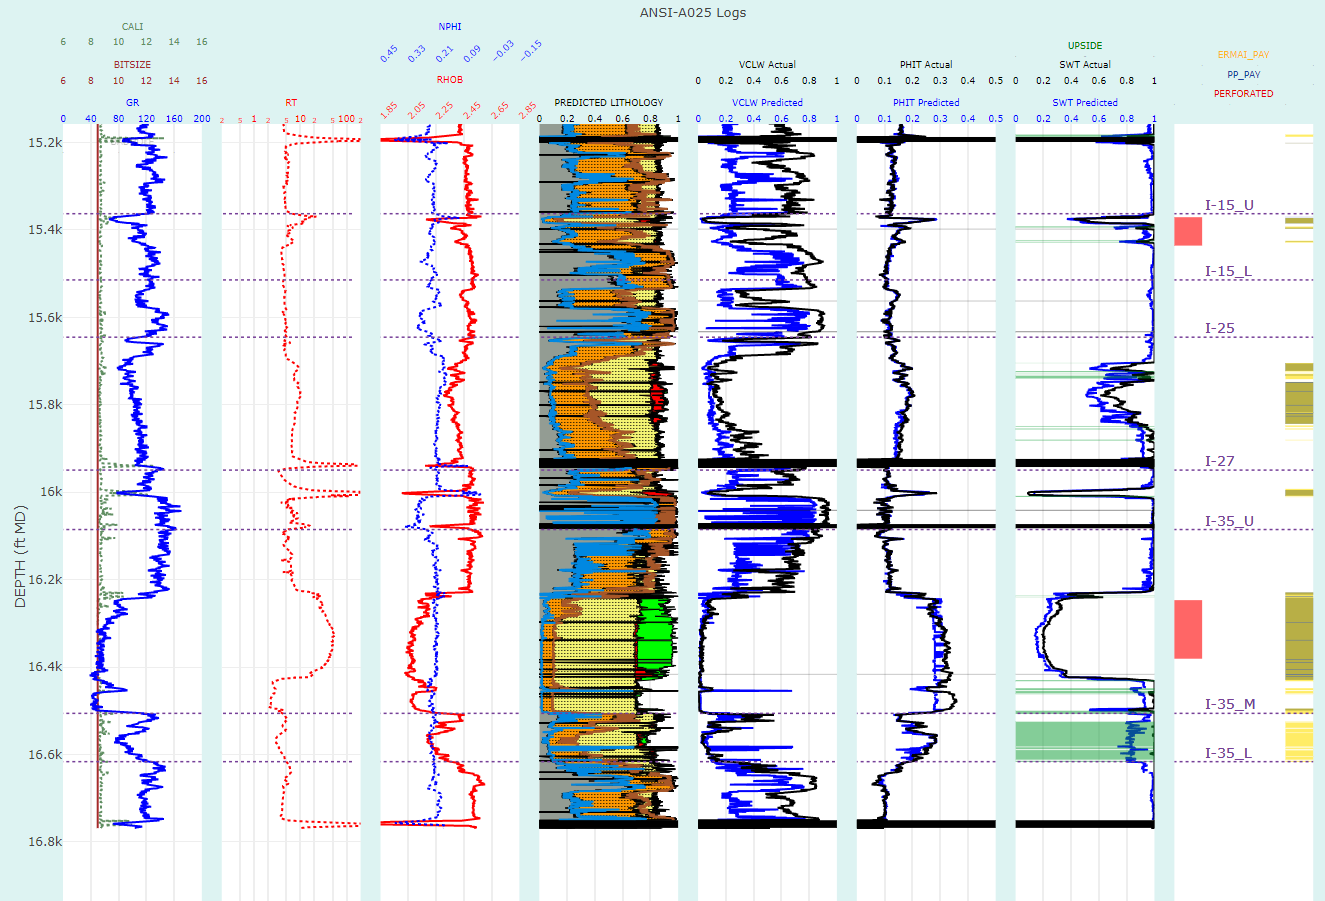

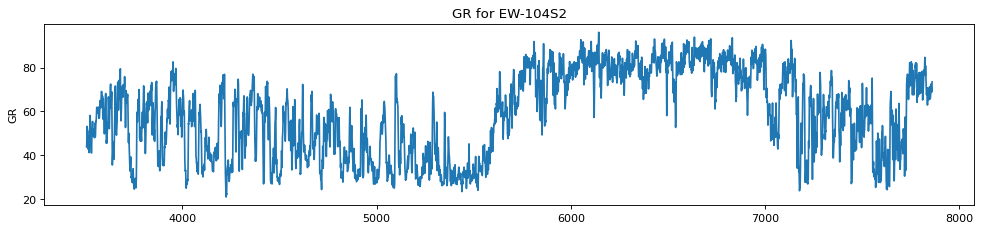

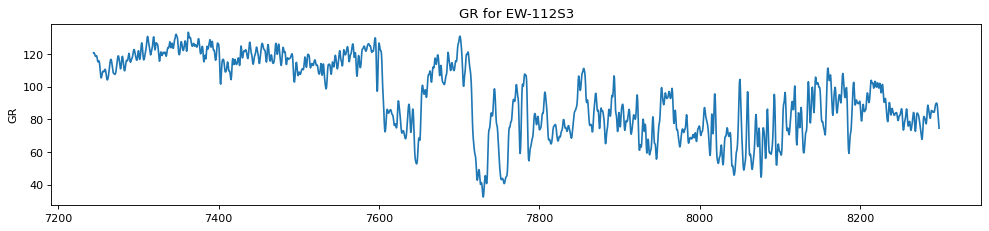

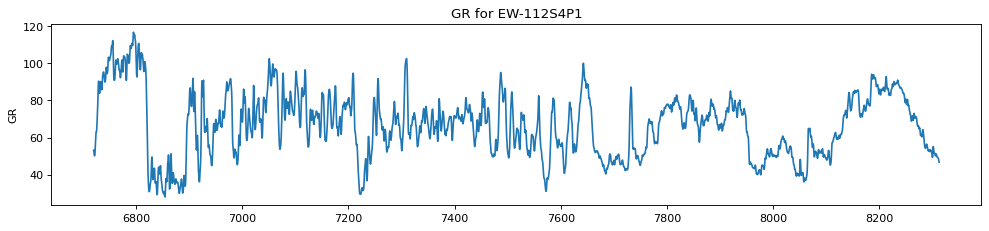

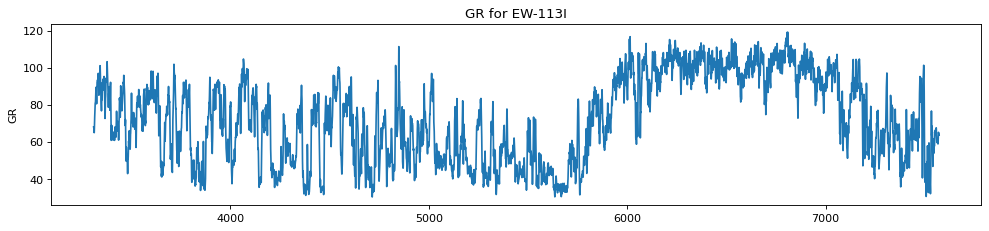

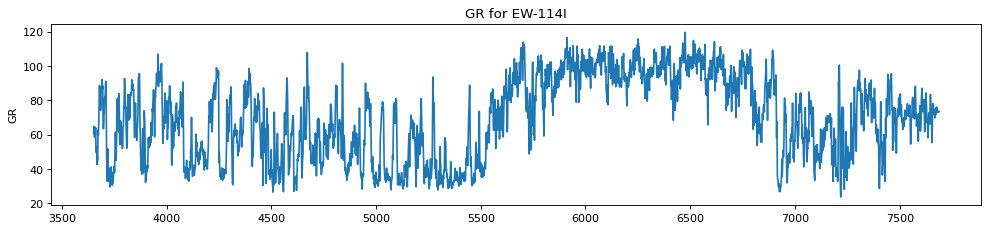

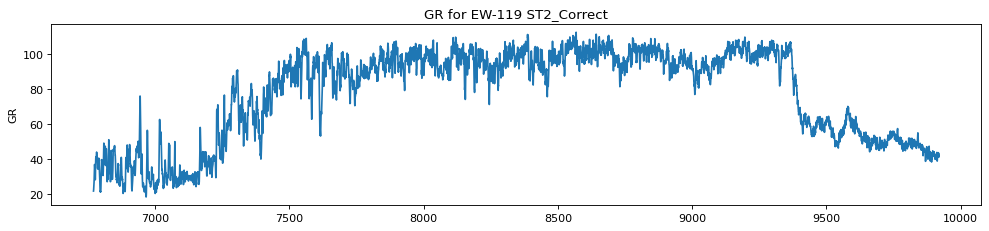

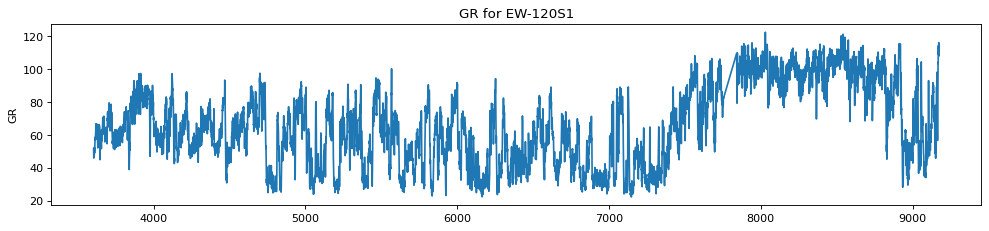

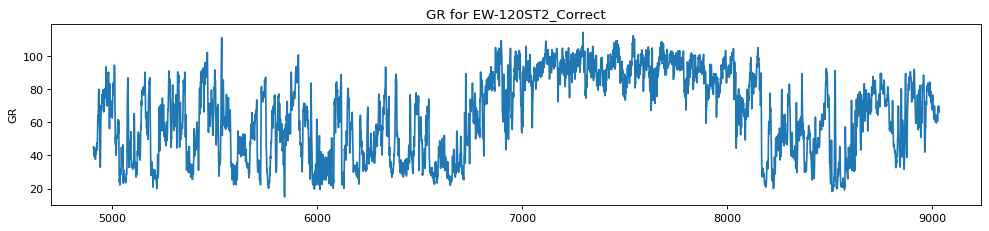

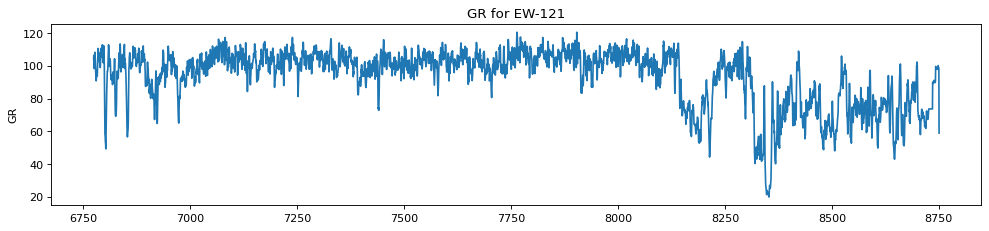

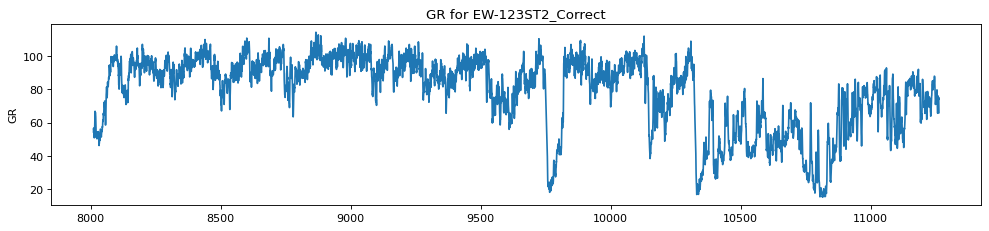

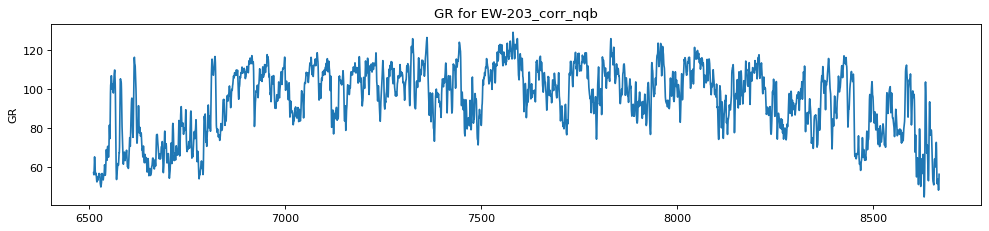

In [14]:
# read and plot data
data_path = 'ERBW_predicted.csv'
data = pd.read_csv(data_path, index_col=0)

for well, well_data in data.groupby('WELL_NAME'):
    plt.figure(figsize=(15, 3), dpi=80)
    plt.plot(well_data['DEPTH'], well_data['GR'])
    plt.ylabel('GR')
    plt.title(f'GR for {well}')

## Model GR for 1 Well

In [15]:
well_1 = data['WELL_NAME'].unique()[0]
data_1 = data[data['WELL_NAME'] == well_1][['GR']].copy()

In [16]:
def create_model(window_size, output_size):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
#         tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation="relu"),
#         tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(output_size),
#         tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mse"])
    return model


def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


def model_forecast_loop(model, series, WINDOW_SIZE,):
    preds = []
    X_init = series.reshape(-1, 1)
    for i in range(WINDOW_SIZE):
        pred = model.predict(X_init[-(WINDOW_SIZE - i)][np.newaxis])
        preds.append(pred)
    return [c.flatten() for c in preds]

In [17]:
SPLIT_TIME = 5000
WINDOW_SIZE = 200
BATCH_SIZE = 25
SHUFFLE_BUFFER_SIZE = 1000
OUTPUT_SIZE = 1

INDEX = data_1.index
SERIES = data_1.GR.values

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(INDEX, SERIES, SPLIT_TIME)

# Apply the transformation to the training set
train_set = windowed_dataset(
    series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE, output_size=OUTPUT_SIZE)

Epoch 1/10
192/192 [==============================] - 11s 47ms/step - loss: 28.7080 - mse: 1507.3506
Epoch 2/10
192/192 [==============================] - 10s 50ms/step - loss: 3.6139 - mse: 49.5005
Epoch 3/10
192/192 [==============================] - 9s 49ms/step - loss: 0.9458 - mse: 3.4142
Epoch 4/10
192/192 [==============================] - 9s 46ms/step - loss: 0.5756 - mse: 1.6555
Epoch 5/10
192/192 [==============================] - 8s 43ms/step - loss: 0.5428 - mse: 1.5045
Epoch 6/10
192/192 [==============================] - 8s 42ms/step - loss: 0.5167 - mse: 1.3839
Epoch 7/10
192/192 [==============================] - 8s 42ms/step - loss: 0.4437 - mse: 1.1626
Epoch 8/10
192/192 [==============================] - 8s 42ms/step - loss: 0.4343 - mse: 1.1130
Epoch 9/10
192/192 [==============================] - 9s 45ms/step - loss: 0.4174 - mse: 1.0565
Epoch 10/10
1/1 [==============================] - 0s 19ms/step

Forecast
 mse: 1.57, mae: 0.95 

Forecast Loop
 mse: 399.44, mae

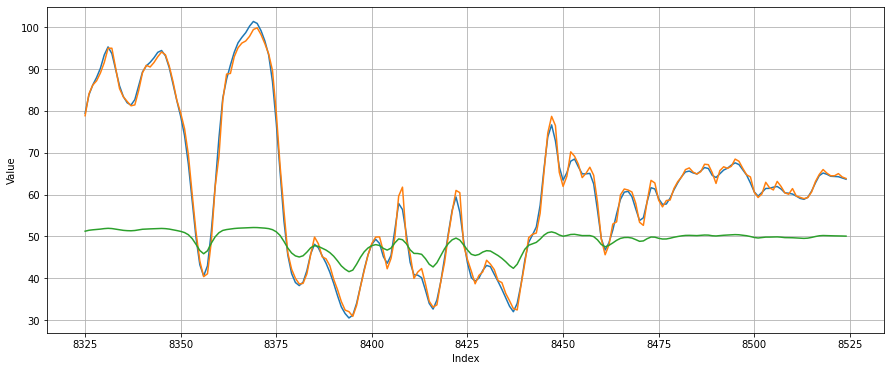

In [18]:
# Save an instance of the model
model = create_model(WINDOW_SIZE, OUTPUT_SIZE)

# Train it
history = model.fit(train_set, epochs=10)

# Compute the forecast for all the series
forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[SPLIT_TIME - WINDOW_SIZE:-1]

# Compute the forecast for all the series
forecast_loop = model_forecast_loop(model, SERIES, WINDOW_SIZE)

# Plot the forecast
plt.figure(figsize=(15, 6))
plot_series(time_valid[-WINDOW_SIZE:], series_valid[-WINDOW_SIZE:])
plot_series(time_valid[-WINDOW_SIZE:], forecast[-WINDOW_SIZE:])
plot_series(time_valid[-WINDOW_SIZE:], forecast_loop[-WINDOW_SIZE:])

mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], forecast[-WINDOW_SIZE:])
print(f"\nForecast\n mse: {mse:.2f}, mae: {mae:.2f} ")
mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], np.array(forecast_loop[-WINDOW_SIZE:]).flatten())
print(f"\nForecast Loop\n mse: {mse:.2f}, mae: {mae:.2f} ")

## Model GR for Multiple Wells

In [19]:
model = create_model(100, 1)

for well, well_data in data.groupby('WELL_NAME'):
    
    SPLIT_TIME = int( 0.5 * len(well_data))
    WINDOW_SIZE = 100
    BATCH_SIZE = 25
    SHUFFLE_BUFFER_SIZE = int( 0.5 * SPLIT_TIME)

    INDEX = well_data.index
    SERIES = well_data.GR.values
    
    time_train, series_train, time_valid, series_valid = train_val_split(INDEX, SERIES, SPLIT_TIME)

    # Apply the transformation to the training set
    train_set = windowed_dataset(
        series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE,
        shuffle_buffer=SHUFFLE_BUFFER_SIZE, output_size=1)
    
    # Train it
    history = model.fit(train_set, epochs=10)

    # Compute the forecast for all the series
    forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()
    # Slice the forecast to get only the predictions for the validation set
    forecast = forecast[SPLIT_TIME - WINDOW_SIZE:-1]

    # Compute the forecast for all the series
    forecast_loop = model_forecast_loop(model, SERIES, WINDOW_SIZE)

    print(f'\n#### Result for {well}')
    mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], forecast[-WINDOW_SIZE:])
    print(f"Forecast\n mse: {mse:.2f}, mae: {mae:.2f} ")
    mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], np.array(forecast_loop[-WINDOW_SIZE:]).flatten())
    print(f"Forecast Loop\n mse: {mse:.2f}, mae: {mae:.2f} ")
    

Epoch 1/10
171/171 [==============================] - 6s 23ms/step - loss: 25.3418 - mse: 1001.3970
Epoch 2/10
171/171 [==============================] - 4s 21ms/step - loss: 6.0167 - mse: 82.1031
Epoch 3/10
171/171 [==============================] - 4s 22ms/step - loss: 0.9603 - mse: 3.9680
Epoch 4/10
171/171 [==============================] - 4s 21ms/step - loss: 0.4586 - mse: 1.2380
Epoch 5/10
171/171 [==============================] - 4s 21ms/step - loss: 0.3746 - mse: 0.9137
Epoch 6/10
171/171 [==============================] - 4s 21ms/step - loss: 0.3660 - mse: 0.8870
Epoch 7/10
171/171 [==============================] - 4s 23ms/step - loss: 0.3210 - mse: 0.7613
Epoch 8/10
171/171 [==============================] - 5s 25ms/step - loss: 0.3455 - mse: 0.8161
Epoch 9/10
171/171 [==============================] - 4s 24ms/step - loss: 0.3115 - mse: 0.7318
Epoch 10/10
1/1 [==============================] - 0s 13ms/step

#### Result for EW-104S2
Forecast
 mse: 1.60, mae: 0.89 
Forecast 

1/1 [==============================] - 0s 21ms/step

#### Result for EW-112S4P1
Forecast
 mse: 0.50, mae: 0.57 
Forecast Loop
 mse: 118.58, mae: 8.41 
Epoch 1/10
167/167 [==============================] - 4s 23ms/step - loss: 0.3867 - mse: 0.9612
Epoch 2/10
167/167 [==============================] - 4s 24ms/step - loss: 0.3979 - mse: 0.9899
Epoch 3/10
167/167 [==============================] - 4s 24ms/step - loss: 0.4081 - mse: 1.0095
Epoch 4/10
167/167 [==============================] - 4s 24ms/step - loss: 0.4004 - mse: 0.9990
Epoch 5/10
167/167 [==============================] - 4s 23ms/step - loss: 0.4358 - mse: 1.0922
Epoch 6/10
167/167 [==============================] - 4s 23ms/step - loss: 0.4127 - mse: 1.0397
Epoch 7/10
167/167 [==============================] - 4s 24ms/step - loss: 0.3801 - mse: 0.9376
Epoch 8/10
167/167 [==============================] - 4s 23ms/step - loss: 0.4490 - mse: 1.1251
Epoch 9/10
167/167 [==============================] - 4s 23ms/step - loss: 0.4332

1/1 [==============================] - 0s 14ms/step

#### Result for EW-119 ST2_Correct
Forecast
 mse: 2.77, mae: 1.35 
Forecast Loop
 mse: 44.59, mae: 6.56 
Epoch 1/10
216/216 [==============================] - 6s 24ms/step - loss: 1.4603 - mse: 5.8808
Epoch 2/10
216/216 [==============================] - 5s 23ms/step - loss: 1.4161 - mse: 5.6304
Epoch 3/10
216/216 [==============================] - 5s 23ms/step - loss: 1.3918 - mse: 5.4699
Epoch 4/10
216/216 [==============================] - 5s 23ms/step - loss: 1.4439 - mse: 5.8187
Epoch 5/10
216/216 [==============================] - 5s 22ms/step - loss: 1.4198 - mse: 5.6406
Epoch 6/10
216/216 [==============================] - 5s 23ms/step - loss: 1.4081 - mse: 5.6017
Epoch 7/10
216/216 [==============================] - 5s 23ms/step - loss: 1.4026 - mse: 5.5206
Epoch 8/10
216/216 [==============================] - 5s 22ms/step - loss: 1.4253 - mse: 5.6689
Epoch 9/10
216/216 [==============================] - 5s 23ms/step - loss:

1/1 [==============================] - 0s 0s/step

#### Result for EW-120ST2_Correct
Forecast
 mse: 1.64, mae: 1.04 
Forecast Loop
 mse: 934.03, mae: 29.86 
Epoch 1/10
76/76 [==============================] - 2s 23ms/step - loss: 2.0560 - mse: 9.8052
Epoch 2/10
76/76 [==============================] - 2s 23ms/step - loss: 2.0860 - mse: 10.1455
Epoch 3/10
76/76 [==============================] - 2s 21ms/step - loss: 1.8762 - mse: 8.4113
Epoch 4/10
76/76 [==============================] - 2s 22ms/step - loss: 1.9119 - mse: 8.7141
Epoch 5/10
76/76 [==============================] - 2s 22ms/step - loss: 1.9000 - mse: 8.7370
Epoch 6/10
76/76 [==============================] - 2s 21ms/step - loss: 1.9023 - mse: 8.6951
Epoch 7/10
76/76 [==============================] - 2s 22ms/step - loss: 1.8811 - mse: 8.3927
Epoch 8/10
76/76 [==============================] - 2s 24ms/step - loss: 1.8541 - mse: 8.4106
Epoch 9/10
76/76 [==============================] - 2s 21ms/step - loss: 1.8359 - mse: 8.2

127/127 [==============================] - 3s 21ms/step - loss: 1.3663 - mse: 5.1645
Epoch 4/10
127/127 [==============================] - 3s 21ms/step - loss: 1.3954 - mse: 5.4097
Epoch 5/10
127/127 [==============================] - 3s 22ms/step - loss: 1.4282 - mse: 5.5165
Epoch 6/10
127/127 [==============================] - 3s 21ms/step - loss: 1.4435 - mse: 5.6002
Epoch 7/10
127/127 [==============================] - 3s 21ms/step - loss: 1.4537 - mse: 5.7209
Epoch 8/10
127/127 [==============================] - 3s 21ms/step - loss: 1.3358 - mse: 5.0215
Epoch 9/10
127/127 [==============================] - 3s 22ms/step - loss: 1.3667 - mse: 5.1863
Epoch 10/10
1/1 [==============================] - 0s 14ms/step

#### Result for EW-123ST2_Correct
Forecast
 mse: 4.08, mae: 1.60 
Forecast Loop
 mse: 1040.20, mae: 31.67 
Epoch 1/10
83/83 [==============================] - 2s 21ms/step - loss: 0.9564 - mse: 3.2117
Epoch 2/10
83/83 [==============================] - 2s 24ms/step - loss: 

1/1 [==============================] - 0s 21ms/step

Forecast
 mse: 1.15, mae: 0.78 

Forecast Loop
 mse: 220.94, mae: 13.59 


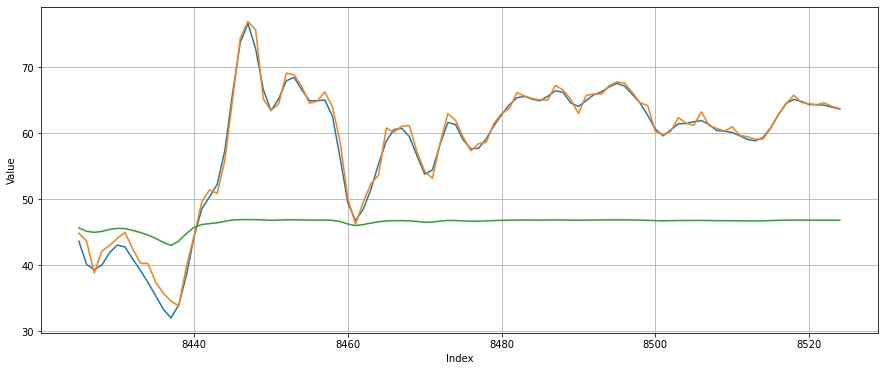

In [20]:
INDEX = data_1.index
SERIES = data_1.GR.values

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(INDEX, SERIES, SPLIT_TIME)

# Compute the forecast for all the series
forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[SPLIT_TIME - WINDOW_SIZE:-1]

# Compute the forecast for all the series
forecast_loop = model_forecast_loop(model, SERIES, WINDOW_SIZE)

# Plot the forecast
plt.figure(figsize=(15, 6))
plot_series(time_valid[-WINDOW_SIZE:], series_valid[-WINDOW_SIZE:])
plot_series(time_valid[-WINDOW_SIZE:], forecast[-WINDOW_SIZE:])
plot_series(time_valid[-WINDOW_SIZE:], forecast_loop[-WINDOW_SIZE:])

mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], forecast[-WINDOW_SIZE:])
print(f"\nForecast\n mse: {mse:.2f}, mae: {mae:.2f} ")
mse, mae = compute_metrics(series_valid[-WINDOW_SIZE:], np.array(forecast_loop[-WINDOW_SIZE:]).flatten())
print(f"\nForecast Loop\n mse: {mse:.2f}, mae: {mae:.2f} ")